# Coherent Z Error Characterization

Coherent Z errors are systematic phase accumulation errors that rotate the qubit state around the Z-axis of the Bloch sphere. Unlike stochastic dephasing (T₂ decay), these errors are deterministic and reproducible from shot to shot. Dynamical Decoupling works by periodically flipping the qubit to refocus phase accumulation. In this notebook, we shall estimate the magnitude of Z errors and motivate the use of DD to kill them. 

## Environment setup 

In [1]:
import os
import numpy as np
from iqm.pulla.pulla import Pulla
from iqm.pulse import Circuit
from iqm.pulse import CircuitOperation as Op
import matplotlib.pyplot as plt

token = os.getenv("IQM_TOKEN")
os.environ["IQM_TOKEN"] = token
server_url = "https://resonance.meetiqm.com/garnet"
p = Pulla(server_url)
compiler = p.get_standard_compiler()

/opt/miniconda3/envs/pulla-tutorial-oak/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/miniconda3/envs/pulla-tutorial-oak/lib/python3.11/site-packages/iqm/iqm_server_client/iqm_server_client.py:150: UserWarning: The given IQM Server URL is in a deprecated format, see the client initialization instructions and correct URL format from the server web dashboard.
  warnings.warn(


## Build characterization circuits

In [2]:
def build_single_wait_instructions_z(layers: list, wait_time: np.ndarray, phase: float)-> list[Op]:
        """
        Concatenate instructions that makes up your z error characterization circuit as Op object and put into a list.

        Args:
            layers: what gate(s) is running while characterization experiment is underway 
            wait_time: delay duration.
            phase: detuning dependent phase to apply to the final PRX gate to maximize the contrast.

        Returns:
            List of instructions that make up your characterization circuit.
        """
        instructions = []
        
        qubits = compiler.builder.chip_topology.qubits_sorted
        excluded_qubits = {qb for pair in layers for qb in pair}
        measure_qubits = compiler.builder.chip_topology.qubits_sorted 
        unique_qubits = [qb for qb in qubits if qb not in excluded_qubits]
        remaining_qubits = [qb for qb in qubits if qb not in excluded_qubits]

        context  = "cz"
        
        for idx, qubit in enumerate(measure_qubits):
            if idx == 0:
                n = int(wait_time // 1e-6)
                instructions += [
                    Op("prx", (qubit,), args={"angle": np.pi / 2, "phase": 0.0}),
                    Op("delay", (qubit,), args={"duration": wait_time}),
                    Op("prx", (qubit,), args={"angle": np.pi / 2, "phase": phase}),
                    ]
            else:
                instructions += [
                    Op("prx", (qubit,), args={"angle": np.pi / 2, "phase": 0.0}),
                    Op("delay", (qubit,), args={"duration": wait_time}),
                    Op("prx", (qubit,), args={"angle": np.pi / 2, "phase": phase})
                ]
        instructions.append(Op("measure", measure_qubits, args={"key": "M"}))
        return instructions




In [3]:
def build_circuits(layers: list, time_axis: np.ndarray, detuning_hz: float) -> list[Circuit]:
        """
        Build the characterization circuits corresponding to z and zz.

        Args:
            layers: what gate(s) is running while characterization experiment is underway 
            time_axis: np array of delays to sweep.
            detuning_hz: drive detuning from qubit frequency to support the fitting.

        Returns:
            quantum circuits corresponding to z and zz characterization experiments.
        """
        circuits = []
        for wait_time in time_axis:
            phase = 2 * np.pi * detuning_hz * wait_time
            instructions = build_single_wait_instructions_z(layers, wait_time, phase)
            circuits.append(Circuit("Z error", instructions))
        return circuits

## Generate playlist for a range of delay times

In [4]:
time_axis = np.linspace(0.0, 10e-6, 101)  
detuning_hz = 5e5/2 #add some detuning for contrast
layers = [] #let us not have any gates in parallel

circuits = build_circuits(layers, time_axis, detuning_hz)
playlist, context = compiler.compile(circuits)
settings, context = compiler.build_settings(context, shots=500)
settings.options.averaging_bins = 1  

job = p.submit_playlist(playlist, settings, context=context)
job.wait_for_completion()

[01-21 13:38:37;I] Submitted a job with ID: 019be090-5b44-77d2-9395-edce1ee9d9db
[01-21 13:38:38;I] Waiting for job 019be090-5b44-77d2-9395-edce1ee9d9db to finish...


Progress in queue:   0%|                                                              | 0/1 [00:40<?, ?it/s]


<JobStatus.COMPLETED: 'completed'>

## Plot 

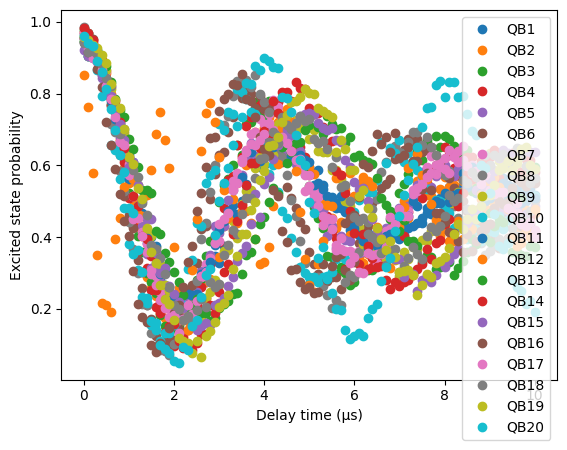

In [5]:
plt.figure()
x_us = time_axis * 1e6
for qubit, qubit_str in enumerate(compiler.builder.chip_topology.qubits_sorted):
    y = np.array([res["M"][0][qubit] for res in job.result()])
    plt.plot(x_us, y, 'o', label=qubit_str)
plt.xlabel("Delay time (µs)")
plt.ylabel("Excited state probability")
plt.legend()
plt.show()

## Extract the error 

In [6]:
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

def with_fft(wait_times, p1_values):
    times = wait_times
    amplitudes = p1_values
    N = len(times)
    yf = fft(amplitudes - np.mean(amplitudes))
    xf = fftfreq(N, times[1] - times[0])
    dominant_freq = np.abs(xf[np.argmax(np.abs(yf))])
    return dominant_freq

def fit_z_coupling(idle_times, p0_values, fixed_over_rotation_freq):
    initial_guess = [0.5,fixed_over_rotation_freq, 0, 0.5, 20e-6]
    params, params_covariance = curve_fit(
        ramsey_decay,
        idle_times,
        p0_values,
        p0=initial_guess,
    )

    A_fit, freq_fit, phase_fit, offset_fit, T2star_fit = params
    freq_GHz = freq_fit
    fitted_curve = ramsey_decay(idle_times, *params)

    return freq_GHz, fitted_curve

def ramsey_decay(t, A, freq, phase, offset, T2star):
    return A * np.exp(-t / T2star) * np.cos(2 * np.pi * freq * t + phase) + offset

qubit_zrates = {}
for qubit, qubit_str in enumerate(compiler.builder.chip_topology.qubits_sorted):
    y = np.array([res["M"][0][qubit] for res in job.result()])
    fftz = with_fft(time_axis, y)
    z_rate, fit_curve = fit_z_coupling(time_axis, y, fftz)
    adjusted = (z_rate - 5e5 / 2) / 1e3
    qubit_zrates[qubit_str] = adjusted

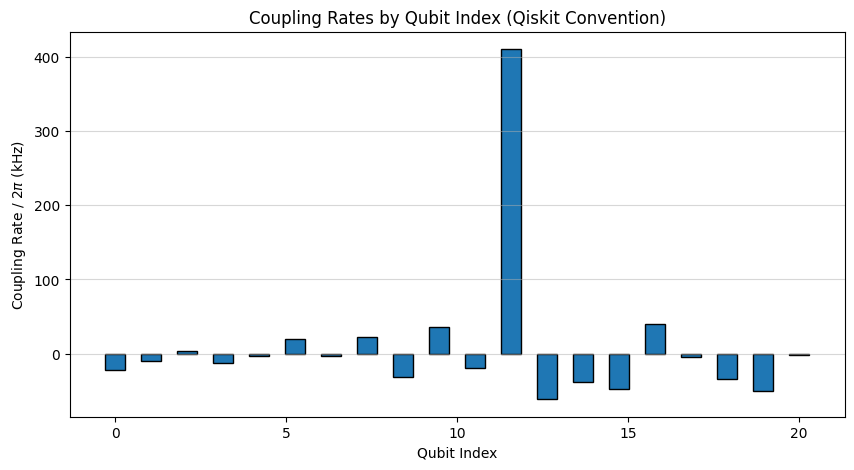

In [7]:
plt.figure(figsize=(10, 5))
bars = plt.bar(np.linspace(0,len(qubit_zrates), len(qubit_zrates)), list(qubit_zrates.values()), width=0.6, edgecolor='black')
plt.xlabel("Qubit Index")
plt.ylabel("Coupling Rate / $2 \\pi$ (kHz)")
plt.title("Coupling Rates by Qubit Index (Qiskit Convention)")
plt.grid(axis='y', alpha=0.5)
plt.show()
